# Employee Retention Prediction
This model will predict whether a employee will leave the company or retain on basis of some features like satisfaction level, last evaluation, no of projects, average monthly hours etc.
- dataset: hr_employee_churn_data.csv

In [1]:
# import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix, make_scorer
import cloudpickle
import dill
import os
import warnings

# settings
SESSION_FILE = "variables.session"
def save_session():
    dill.dump_session(SESSION_FILE)
    print(f"Session saved to {SESSION_FILE}")
def load_session():
    if os.path.exists(SESSION_FILE):
        dill.load_session(SESSION_FILE)
        print(f"Session loaded from {SESSION_FILE}")
    else:
        print("No saved session found.")
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",None)

In [2]:
# load everything
load_session()

Session loaded from variables.session


In [24]:
# load dataset
data = pd.read_csv("hr_employee_churn_data.csv")
data.head()

,empid,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,left
0,1,0.38,0.53,2,157,3,0,0,low,1
1,2,0.80,0.86,5,262,6,0,0,medium,1
2,3,0.11,0.88,7,272,4,0,0,medium,1
3,4,0.72,0.87,5,223,5,0,0,low,1
4,5,0.37,0.52,2,159,3,0,0,low,1


In [25]:
# data backup
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   empid                  14999 non-null  int64  
 1   satisfaction_level     14997 non-null  float64
 2   last_evaluation        14999 non-null  float64
 3   number_project         14999 non-null  int64  
 4   average_montly_hours   14999 non-null  int64  
 5   time_spend_company     14999 non-null  int64  
 6   Work_accident          14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   salary                 14999 non-null  object 
 9   left                   14999 non-null  int64  
dtypes: float64(2), int64(7), object(1)
memory usage: 1.1+ MB


# Data Preprocessing

In [26]:
# dropping irrelevant columns
df.drop(columns='empid',axis=1,inplace=True)
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,left
0,0.38,0.53,2,157,3,0,0,low,1
1,0.80,0.86,5,262,6,0,0,medium,1
2,0.11,0.88,7,272,4,0,0,medium,1
3,0.72,0.87,5,223,5,0,0,low,1
4,0.37,0.52,2,159,3,0,0,low,1


In [27]:
# duplicates
df.drop_duplicates(inplace= True)
print(f'no of rows reduced to {df.shape[0]}')

no of rows reduced to 11961


In [28]:
# null values
df.dropna(inplace= True)
print(f'no of rows reduced to {df.shape[0]}')

no of rows reduced to 11959


In [29]:
# outliers
df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,left
count,11959.000000,11959.000000,11959.000000,11959.000000,11959.000000,11959.000000,11959.000000,11959.000000
mean,0.630334,0.717010,3.805084,200.542437,3.365248,0.154695,0.016975,0.163893
std,0.240871,0.168241,1.160503,48.685922,1.331699,0.361629,0.129182,0.370194
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.490000,0.570000,3.000000,158.000000,3.000000,0.000000,0.000000,0.000000
50%,0.660000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.860000,5.000000,243.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


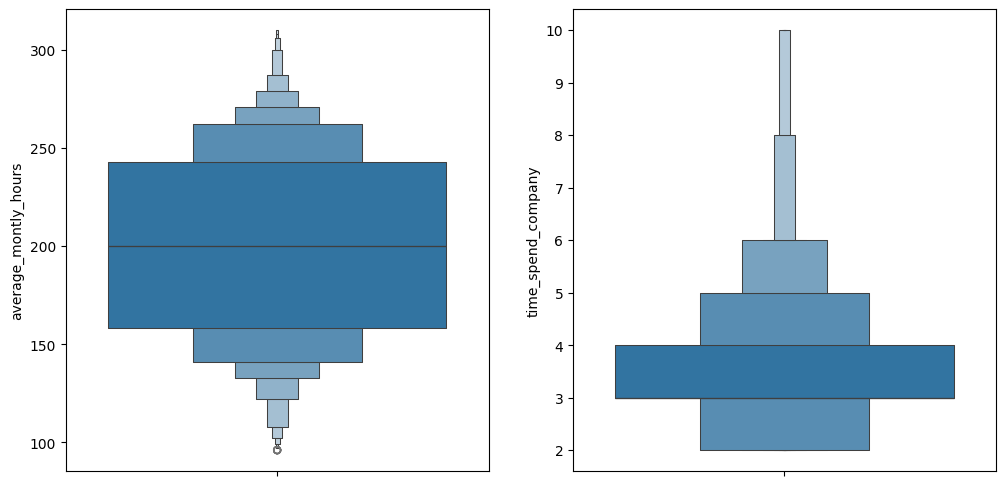

In [30]:
# outliers visualisation
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
sns.boxenplot(y='average_montly_hours', data = df, ax=ax[0])
sns.boxenplot(y='time_spend_company', data = df, ax=ax[1])
plt.show()          # no outliers

In [31]:
# save data
file_name = "hr_employee_churn_data_cleaned.csv"
df.to_csv(file_name, index= False)
print(f"data saved as {file_name}")

data saved as hr_employee_churn_data_cleaned.csv


In [32]:
# numeric and non numeric columns
non_numeric_columns = df.select_dtypes(include= ['object']).columns.to_list()
numeric_columns = df.select_dtypes(exclude= ['object']).columns.to_list()
print(f'non numeric columns: {non_numeric_columns}')
print(f'numeric columns: {numeric_columns}')

# # data encoding
label = LabelEncoder()
df['salary'] = label.fit_transform(df['salary'])
df.head()

non numeric columns: ['salary']
numeric columns: ['satisfaction_level', 'last_evaluation', 'number_project', 'average_montly_hours', 'time_spend_company', 'Work_accident', 'promotion_last_5years', 'left']


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,left
0,0.38,0.53,2,157,3,0,0,1,1
1,0.80,0.86,5,262,6,0,0,2,1
2,0.11,0.88,7,272,4,0,0,2,1
3,0.72,0.87,5,223,5,0,0,1,1
4,0.37,0.52,2,159,3,0,0,1,1


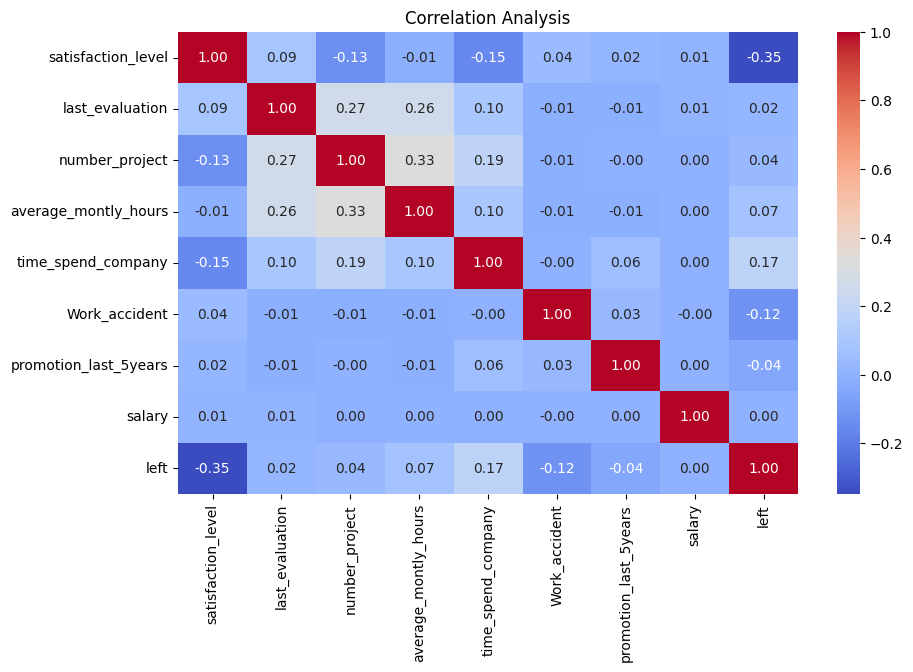

In [33]:
# correlation analysis
corr = df.corr()
plt.figure(figsize= (10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Analysis")
plt.show()

# Model Training and Hyperparameter Tuning

In [34]:
# setting feature and target
x = df.drop(columns= ['left'])
y = df['left']
numeric_columns.remove('left')

# Preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_columns),
    ('cat', OneHotEncoder(handle_unknown= 'ignore', sparse_output= False), non_numeric_columns)
])

# split dataset
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.2, random_state= 42)

# data preprocessing
x_train = preprocessor.fit_transform(x_train)
x_test = preprocessor.fit_transform(x_test)

In [ ]:
# model details
model_dict = {
    'logistic regression': LogisticRegression(max_iter= 1000),
    'ridge': RidgeClassifier(max_iter= 1000),
    'decision tree': DecisionTreeClassifier(random_state= 42),
    'random forest': RandomForestClassifier(random_state= 42),
    'AdaBoost': AdaBoostClassifier(algorithm= 'SAMME', random_state= 42),
    'gradient boosting': GradientBoostingClassifier(random_state= 42),
    'XGBoost': XGBClassifier(use_label_encoder= False, eval_matrics= 'logloss'),
    'lightgbm': LGBMClassifier(),
    'catboost': CatBoostClassifier(),
    'SVC': SVC(probability= True),
    'linear SVC': LinearSVC(random_state= 42),
}

# hyperparameter details
search_space = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'iterations': [500, 1000, 1500, 2000],
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'max_iter': [1000, 2000],
    'n_estimator': [0, 50, 100, 150],
    'max_depth': [None, 5, 10, 15, 20],
    'border_count': [50, 100, 150, 200],
    'num_leaves': [50, 00, 50, 200],
    'l2_leaf_reg': [1, 5, 10],
    'depth': [None, 5, 10, 15, 20],
    'learning_rate': [0.1, 0.5, 1],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 15, 20],
    'max_leaf_nodes': [5, 10, 15, 20],
    'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
}
catboost_search_space = {
    'learning_rate': [0.08, 0.085, 0.09],
    'iterations': [1000],
    'depth': [4, 6, 8], 
}

# filter hyperparameter
def filter_hyperparameter(model, space):
    if isinstance(model, CatBoostClassifier):
        return catboost_search_space
    valid_key = model.get_params()
    param_grid = {k:v for k,v in space.items() if k in valid_key}
    return param_grid

In [36]:
# model training with grid search
result = []
i = 0
for name, model in model_dict.items():
    print(f'Tuning for {name}')
    param_grid = filter_hyperparameter(model, search_space)
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted'),
    }
    grid = GridSearchCV(estimator= model, param_grid= param_grid, cv= 5, scoring= scoring, refit= 'accuracy', n_jobs= -1)
    grid.fit(x_train, y_train)
    best_model = grid.best_estimator_
    y_predict = best_model.predict(x_test)
    report = classification_report(y_test, y_predict, output_dict= True)
    conf = confusion_matrix(y_test, y_predict)
    result.append({
        'model_name': name,
        'best_parameter': grid.best_params_,
        'accuracy': round(accuracy_score(y_test, y_predict), 4),
        'F1_score': round(report['weighted avg']['f1-score'], 4),
        'precision': round(report['weighted avg']['precision'], 4),
        'recall': round(report['weighted avg']['recall'], 4),
    })
    i+=1
print('model tuning completed')

Tuning for logistic regression
Tuning for ridge
Tuning for decision tree
Tuning for random forest
Tuning for AdaBoost
Tuning for gradient boosting
Tuning for XGBoost
Tuning for lightgbm
[LightGBM] [Info] Number of positive: 1564, number of negative: 8003
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 403
[LightGBM] [Info] Number of data points in the train set: 9567, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.163479 -> initscore=-1.632570
[LightGBM] [Info] Start training from score -1.632570
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

In [38]:
# finding best model
model_df = pd.DataFrame(result)
model_df.sort_values(by= 'accuracy', ascending= False, inplace= True)
best_model = model_df.iloc[0]['model_name']
best_parameter = model_df.iloc[0]['best_parameter']
print("best model is:", best_model)
print("best parameter is:", best_parameter)
model_df

best model is: gradient boosting
best parameter is: {'learning_rate': 0.1, 'max_depth': None, 'max_leaf_nodes': 20, 'min_samples_leaf': 15, 'min_samples_split': 5}


,model_name,best_parameter,accuracy,F1_score,precision,recall
5,gradient boosting,"{'learning_rate': 0.1, 'max_depth': None, 'max...",0.9816,0.9813,0.9817,0.9816
8,catboost,"{'depth': 4, 'iterations': 1000, 'learning_rat...",0.9816,0.9813,0.9816,0.9816
7,lightgbm,"{'boosting_type': 'gbdt', 'learning_rate': 0.1...",0.9812,0.9809,0.9812,0.9812
6,XGBoost,"{'learning_rate': 0.1, 'max_depth': 15}",0.9795,0.9791,0.9795,0.9795
2,decision tree,"{'max_depth': None, 'max_leaf_nodes': 20, 'min...",0.9783,0.9779,0.9782,0.9783
3,random forest,"{'max_depth': None, 'max_leaf_nodes': 20, 'min...",0.9753,0.9748,0.9753,0.9753
9,SVC,"{'C': 10, 'kernel': 'rbf', 'max_iter': 1000}",0.9703,0.9701,0.9700,0.9703
4,AdaBoost,{'learning_rate': 1},0.9490,0.9476,0.9477,0.9490
1,ridge,"{'alpha': 0.1, 'max_iter': 1000}",0.8424,0.7929,0.8136,0.8424
10,linear SVC,"{'C': 10, 'max_iter': 1000}",0.8411,0.8047,0.8080,0.8411


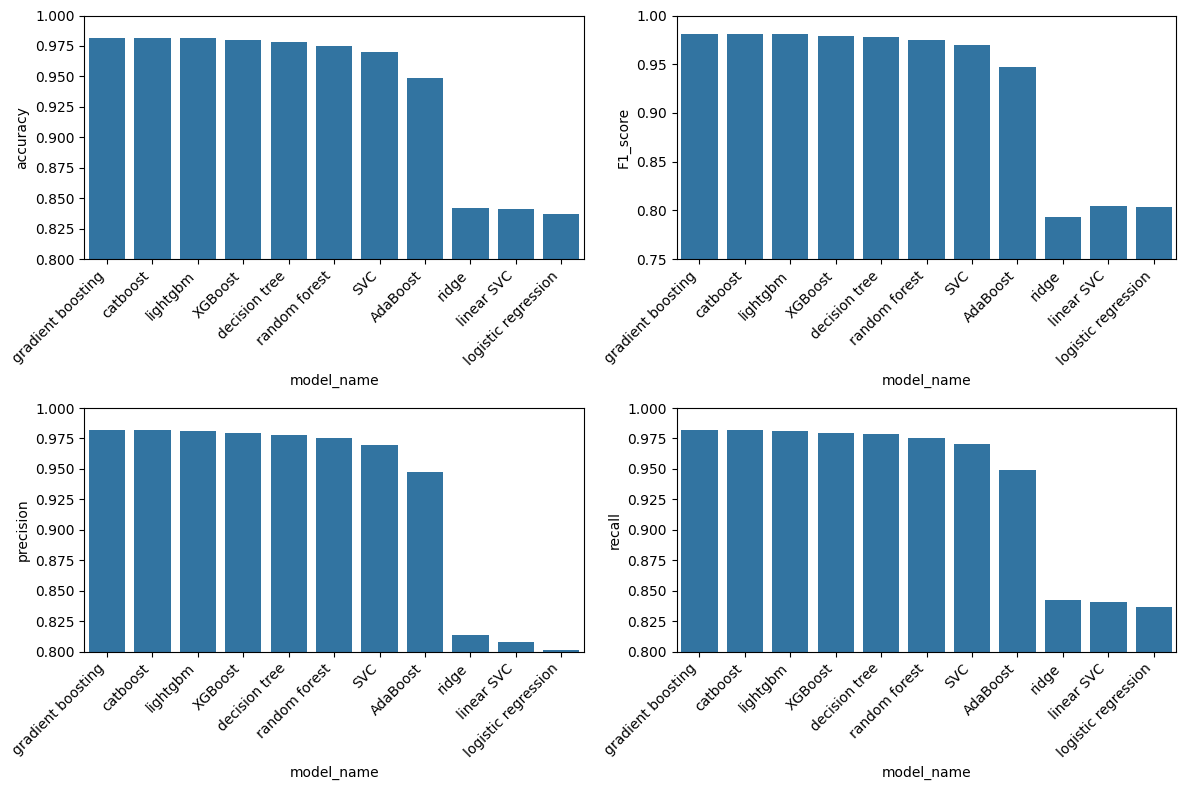

In [40]:
# ploting the netrics
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# accuracy
sns.barplot(x='model_name', y='accuracy', data=model_df, ax=ax[0][0])
ax[0][0].set_ylim(0.8, 1)
ax[0][0].set_xticklabels(ax[0][0].get_xticklabels(), rotation=45, ha='right')

# F1-Score
sns.barplot(x='model_name', y='F1_score', data=model_df, ax=ax[0][1])
ax[0][1].set_ylim(0.75, 1)
ax[0][1].set_xticklabels(ax[0][1].get_xticklabels(), rotation=45, ha='right')

# Precision
sns.barplot(x='model_name', y='precision', data=model_df, ax=ax[1][0])
ax[1][0].set_ylim(0.8, 1)
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(), rotation=45, ha='right')

# Recall
sns.barplot(x='model_name', y='recall', data=model_df, ax=ax[1][1])
ax[1][1].set_ylim(0.8, 1)
ax[1][1].set_xticklabels(ax[1][1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [3]:
# final model
final_model = model_dict[best_model].set_params(**best_parameter)

# final training and testing
final_model.fit(x_train, y_train)
y_predict = final_model.predict(x_test)

# model evaluation
accuracy = accuracy_score(y_test, y_predict)
conf = confusion_matrix(y_test, y_predict)
report = classification_report(y_test, y_predict)

print('best model: ',best_model)
print('accuracy score: ',accuracy)
print('\nconfusion matrix:\n',conf)
print('\nclassification report:\n',report)

best model:  gradient boosting
accuracy score:  0.9816053511705686

confusion matrix:
 [[1991    5]
 [  39  357]]

classification report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1996
           1       0.99      0.90      0.94       396

    accuracy                           0.98      2392
   macro avg       0.98      0.95      0.97      2392
weighted avg       0.98      0.98      0.98      2392



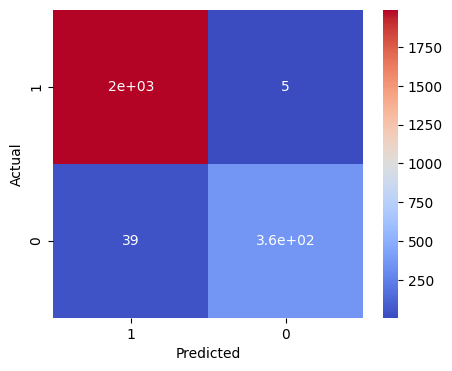

True Values: 2348
Fake Values: 44


In [6]:
# visualizing confusion matrix
plt.figure(figsize= (5,4))
sns.heatmap(conf, annot= True, cmap= 'coolwarm', xticklabels= y.unique(), yticklabels= y.unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
print(f'True Values: {conf[0][0] + conf[1][1]}')
print(f'Fake Values: {conf[1][0] + conf[0][1]}')

In [43]:
# retrain model
x = preprocessor.fit_transform(x)
final_model.fit(x, y)

# pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', final_model)
])

# save model
model_name = "model.pkl"
with open(model_name, 'wb') as f:
    cloudpickle.dump(pipeline, f)
print(f'model saved as {model_name}')

model saved as model.pkl


In [44]:
# save everything
save_session()

Session saved to variables.session
